In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import torch
import matplotlib.pyplot as plt
from tqdm import trange

from IPython.display import clear_output

from steganogan import SteganoGAN
from rnns_utils import BasicDecoder, shuffle_params, load_image_and_target, save_image, error_rate, HammingLoss, hamming_valid
from rnns import step_lbfgs
from hamming_torch import Hamming74

## Configurations

In [14]:
num_bits = 3                 # bits per pixel
hidden_size = 128            # model width
pretrained = False           # whether to use pretrained model
pretrained_path = None       # pretrained model's path
flatten_image = False        # whether to split the image by channel and combine as a 3x larger grayscale image
hamming = True               # whether to use hamming code

steps = 2000
max_iter = 20
lr = 0.1
eps = 0.105

img_path = "./data/img.png"

## Initialize model

In [15]:
if hamming:
    hm = Hamming74()
    bits = math.ceil(num_bits * 7 / 4)
    print(f"using hamming code, payload is {bits} bits per pixel.")
else:
    bits = num_bits
    hm = None

using hamming code, payload is 6 bits per pixel.


In [16]:
if pretrained:
    steganogan = SteganoGAN.load(path=pretrained_path, cuda=True, verbose=True)
    model = steganogan.decoder
else:
    model = BasicDecoder(bits, hidden_size, flatten_image)

print(model)

BasicDecoder(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): normLayer()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace)
    (5): normLayer()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace)
    (8): normLayer()
    (9): Conv2d(128, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


## Load image and generate target

Set random seed to 1
image: torch.Size([1, 3, 225, 300]), target: torch.Size([354375])


Text(0.5, 1.0, 'original image')

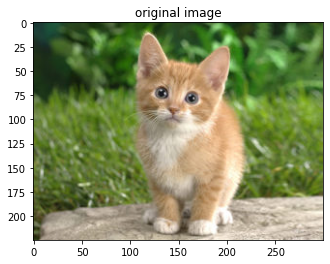

In [17]:
image, real_target = load_image_and_target(img_path, num_bits, flatten_image, seed=1)
target = hm.encode(real_target.view(-1)).float().view(-1) if hamming else real_target.clone()

model.apply(shuffle_params)
model.to('cuda')

print(f"image: {image.shape}, target: {target.shape}")
plt.imshow(image.cpu().numpy()[0].transpose(1, 2, 0))
plt.title("original image")

## Perform Random Neural Network Steganography

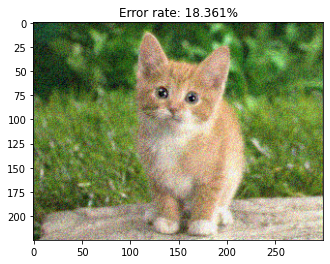

100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


In [18]:
epsilon = eps - 0.0005
adv_image = image.clone().detach()

for i in trange(steps // max_iter):
    adv_image = step_lbfgs(adv_image, image, target, model, lr, max_iter, epsilon)

    err = error_rate(model, adv_image, target, real_target, hm)
    
    clear_output(wait=True)
    plt.imshow(adv_image.cpu().numpy()[0].transpose(1, 2, 0))
    plt.title(f"Error rate: {err*100:0.3f}%")
    plt.show()
    
    if (hamming and hamming_valid(model, adv_image, target)) or err == 0:
        break
        
if hamming:
    for i in trange(steps // max_iter):
        adv_image = step_lbfgs(adv_image, image, target, model, lr, max_iter, epsilon, criterion=HammingLoss())

        err = error_rate(model, adv_image, target, real_target, hm)

        clear_output(wait=True)
        plt.imshow(adv_image.cpu().numpy()[0].transpose(1, 2, 0))
        plt.title(f"Error rate: {err*100:0.3f}%")
        plt.show()

        if (hamming and hamming_valid(model, adv_image, target)) or err == 0:
            break

In [ ]:
save_image(adv_image, "./img_out.png")